In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col

from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors

spark = SparkSession.Builder().appName('DDAM_Project_north').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 20:47:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/North_Incidents_Cleaned.csv')

In [3]:
df.count()

83267

In [4]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T

23/12/14 20:47:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0
Severity,0
Start_Time,0
Start_Lat,0
Start_Lng,0
Distance_mi,0
City,0
County,0
State,0
Temperature_F,0
Wind_Chill_F,0


In [5]:
df=df.drop('Wind_Chill_F')

Preparing data

In [6]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
df_class.show()

+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+----+---------------+---------------------+-----------------+
|Severity|         Start_Lat|         Start_Lng|       Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Weather_Condition|
+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+----+---------------+---------------------+-----------------+
|       3|         41.877678|        -86.088089|    

In [7]:
colonne_booleane = ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))

df_class.show()

+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+-----------------+
|Severity|         Start_Lat|         Start_Lng|       Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Weather_Condition|
+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+-----------------+
|       3|         41.877678|        -86.088089|       

In [8]:
from pyspark.sql.functions import when, count, isnull



df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))


df_class.show()

+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+-----------------+
|Severity|         Start_Lat|         Start_Lng|       Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Weather_Condition|
+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+-----------------+
|       3|         41.877678|        -86.088089|       

In [9]:
indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
df_class = indexer.fit(df_class).transform(df_class)

from pyspark.ml.feature import OneHotEncoder
onehotencoder_vector = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_1hot")
df_class = onehotencoder_vector.fit(df_class).transform(df_class)

df_class=df_class.drop('Weather_Condition')
#df_class.show()
df_class=df_class.drop('Weather_Condition_Indexed')
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Severity")

df_rf= df_class.withColumn("Severity", col("Severity") - 1)
df_rf.show()

+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+----------------------+
|Severity|         Start_Lat|         Start_Lng|       Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Weather_Condition_1hot|
+--------+------------------+------------------+------------------+-------------+-------------+-------------+--------------+----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+----------------------+
|       2|         41.877678|        -86

In [10]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_rf)

classificationData = output_dataset.select("features", "Severity")

classificationData.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                      |Severity|
+------------------------------------------------------------------------------------------------------------------------------+--------+
|(27,[0,1,3,4,5,6,19,20,24],[41.877678,-86.088089,30.0,64.0,10.0,13.0,2.0,15.0,1.0])                                           |2       |
|(27,[0,1,2,3,4,5,6,19,20,24],[41.883412599363886,-86.07864260632476,0.647,30.0,64.0,10.0,13.0,2.0,15.0,1.0])                  |1       |
|(27,[0,1,2,3,4,5,6,19,20,24],[41.883422,-86.07864599999998,0.927,30.0,64.0,10.0,10.0,2.0,16.0,1.0])                           |1       |
|(27,[0,1,2,3,4,5,6,19,20,24],[41.883412599363886,-86.07864260632476,0.647,30.0,64.0,10.0,10.0,2.0,16.0,1.0])                  |1       |
|(27,[0,1,3,4,5,6,19,20,23],[42.29

In [11]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
 
# Train a RandomForest model.
for max_depth in range (5,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=max_depth)
    
    
    # Train model.  This also runs the indexers.
    model = rf.fit(trainingData)
    
    
    # Make predictions.
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")
    
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Max Depth : ",max_depth)
    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem
    
    avg_f1=sum_/4
    print('----------------------')
    
    print("avg_F1-Score: {:.2%}".format(avg_f1))

0.940178141550313
Test Error = 0.0598219


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Max Depth :  5


Precision for class  0 : 74.57%
Recall for class  0 : 47.07%
avg_F1-Score for class  0 : 57.71%
----------------------------
Precision for class  1 : 94.72%
Recall for class  1 : 99.36%
avg_F1-Score for class  1 : 96.99%
----------------------------
Precision for class  2 : 56.11%
Recall for class  2 : 27.82%
avg_F1-Score for class  2 : 37.20%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.5771276595744681, 0.9698678562410571, 0.37199124726477023, 0.0]
----------------------
avg_F1-Score: 47.97%


0.9473599743219387
Test Error = 0.05264


Max Depth :  10


Precision for class  0 : 74.61%
Recall for class  0 : 61.82%
avg_F1-Score for class  0 : 67.62%
----------------------------
Precision for class  1 : 95.73%
Recall for class  1 : 98.98%
avg_F1-Score for class  1 : 97.33%
----------------------------
Precision for class  2 : 66.25%
Recall for class  2 : 60.39%
avg_F1-Score for class  2 : 63.18%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.6761565836298932, 0.9732915041546549, 0.6318493150684932, 0.0]
----------------------
avg_F1-Score: 57.03%


23/12/14 20:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1217.1 KiB
23/12/14 20:49:12 WARN DAGScheduler: Broadcasting large task binary with size 1608.5 KiB
23/12/14 20:49:13 WARN DAGScheduler: Broadcasting large task binary with size 2032.7 KiB
23/12/14 20:49:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/14 20:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1341.2 KiB


0.9443508265125983
Test Error = 0.0556492


23/12/14 20:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB


Max Depth :  15


23/12/14 20:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1341.2 KiB


Precision for class  0 : 73.15%
Recall for class  0 : 68.55%
avg_F1-Score for class  0 : 70.77%
----------------------------
Precision for class  1 : 95.83%
Recall for class  1 : 98.56%
avg_F1-Score for class  1 : 97.17%
----------------------------
Precision for class  2 : 67.30%
Recall for class  2 : 58.27%
avg_F1-Score for class  2 : 62.46%
----------------------------
Precision for class  3 : 5.50%
Recall for class  3 : 0.91%
avg_F1-Score for class  3 : 1.56%
----------------------------
[0.7077267637178052, 0.9717309981295698, 0.6245614035087719, 0.01564537157757497]
----------------------
avg_F1-Score: 57.99%


23/12/14 20:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1217.1 KiB
23/12/14 20:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1608.5 KiB
23/12/14 20:49:31 WARN DAGScheduler: Broadcasting large task binary with size 2032.7 KiB
23/12/14 20:49:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/14 20:49:33 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/14 20:49:34 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/12/14 20:49:35 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/12/14 20:49:37 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/14 20:49:38 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/12/14 20:49:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


0.938613384689456
Test Error = 0.0613866


23/12/14 20:49:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Max Depth :  20


23/12/14 20:49:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Precision for class  0 : 71.63%
Recall for class  0 : 66.81%
avg_F1-Score for class  0 : 69.14%
----------------------------
Precision for class  1 : 95.83%
Recall for class  1 : 97.92%
avg_F1-Score for class  1 : 96.86%
----------------------------
Precision for class  2 : 65.31%
Recall for class  2 : 57.94%
avg_F1-Score for class  2 : 61.41%
----------------------------
Precision for class  3 : 7.97%
Recall for class  3 : 3.04%
avg_F1-Score for class  3 : 4.40%
----------------------------
[0.691358024691358, 0.9686320503251946, 0.614050303555941, 0.044004400440044]
----------------------
avg_F1-Score: 57.95%


<Axes: >

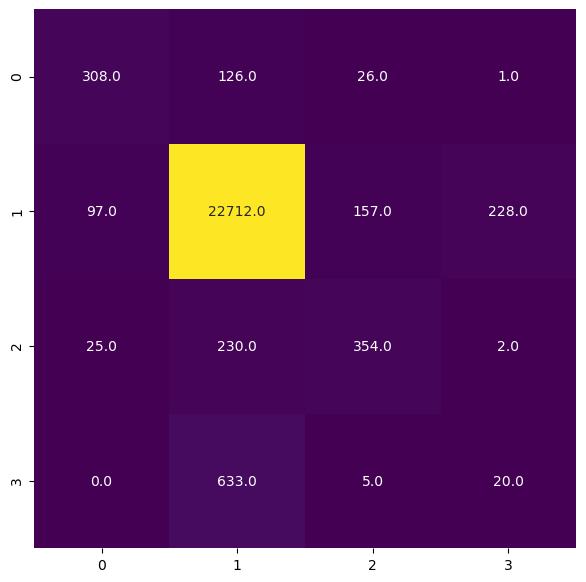

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [14]:
model.featureImportances

SparseVector(27, {0: 0.1074, 1: 0.1009, 2: 0.312, 3: 0.0882, 4: 0.0622, 5: 0.0175, 6: 0.0562, 7: 0.0116, 8: 0.0009, 9: 0.0083, 10: 0.0018, 11: 0.0091, 12: 0.0005, 13: 0.0004, 15: 0.0038, 16: 0.0024, 17: 0.0003, 18: 0.0194, 19: 0.0627, 20: 0.0804, 21: 0.0191, 22: 0.0069, 23: 0.0107, 24: 0.0102, 25: 0.0039, 26: 0.0033})

In [15]:
predictions.select('prediction').distinct().collect()

23/12/14 20:49:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/14 20:49:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


[Row(prediction=0.0),
 Row(prediction=1.0),
 Row(prediction=3.0),
 Row(prediction=2.0)]

In [16]:
prediction_counts = predictions.groupBy("prediction").count()

# Stampare i risultati
print("Counts of predictions in the test set:")
prediction_counts.show()

Counts of predictions in the test set:


23/12/14 20:49:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  430|
|       1.0|23701|
|       3.0|  251|
|       2.0|  542|
+----------+-----+



23/12/14 20:49:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


In [17]:
prediction_counts = predictions.groupBy("Severity").count()

# Stampare i risultati
prediction_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|23194|
|       3|  658|
|       2|  611|
|       0|  461|
+--------+-----+



In [18]:
severity_counts_train= trainingData.groupBy("Severity").count()

# Mostra il risultato
severity_counts_train.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|54316|
|       3| 1513|
|       2| 1517|
|       0|  997|
+--------+-----+



In [19]:
severity_counts_test= testData.groupBy("Severity").count()

# Mostra il risultato
severity_counts_test.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|23194|
|       3|  658|
|       2|  611|
|       0|  461|
+--------+-----+



In [20]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql import functions as F

#important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix())

23/12/14 20:50:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/14 20:50:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/12/14 20:50:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/14 20:50:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


DenseMatrix([[3.0800e+02, 1.2600e+02, 2.6000e+01, 1.0000e+00],
             [9.7000e+01, 2.2712e+04, 1.5700e+02, 2.2800e+02],
             [2.5000e+01, 2.3000e+02, 3.5400e+02, 2.0000e+00],
             [0.0000e+00, 6.3300e+02, 5.0000e+00, 2.0000e+01]])


# UNDERSAMPLING
Performing Undersampling(Severity=1) on trainingData

Undersampling -> Faccio una media delle occorrenze delle altre tre classi e riduco la classe di maggioranza a quel numero

In [21]:
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g_p=g.toPandas()
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]
n_2=g_p.iloc[2,1]
n_3=g_p.iloc[3,1]

In [22]:
und=(n_0+n_2+n_3)/3
train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})
result_counts=train_und.groupBy("Severity").count()
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1277|
|       3| 1513|
|       2| 1517|
|       0|  997|
+--------+-----+



Training & Testing random forest with training Data sampled

In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
 
# Train a RandomForest model.
for max_depth in range (5,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=max_depth)
    
    
    # Train model.  This also runs the indexers.
    model = rf.fit(train_und)
    
    
    # Make predictions.
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")
    
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Max Depth : ",max_depth)
    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem
    
    avg_f1=sum_/4
    print('----------------------')
    
    print("avg_F1-Score: {:.2%}".format(avg_f1))

0.5897528486599262
Test Error = 0.410247


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Max Depth :  5


Precision for class  0 : 56.98%
Recall for class  0 : 85.90%
avg_F1-Score for class  0 : 68.51%
----------------------------
Precision for class  1 : 98.83%
Recall for class  1 : 57.39%
avg_F1-Score for class  1 : 72.61%
----------------------------
Precision for class  2 : 31.65%
Recall for class  2 : 79.05%
avg_F1-Score for class  2 : 45.20%
----------------------------
Precision for class  3 : 5.51%
Recall for class  3 : 77.36%
avg_F1-Score for class  3 : 10.29%
----------------------------
[0.685121107266436, 0.7261271581703624, 0.45203556387459054, 0.10291144359078044]
----------------------
avg_F1-Score: 49.15%


0.649534585138822
Test Error = 0.350465
Max Depth :  10


Precision for class  0 : 56.23%
Recall for class  0 : 88.07%
avg_F1-Score for class  0 : 68.64%
----------------------------
Precision for class  1 : 98.93%
Recall for class  1 : 63.60%
avg_F1-Score for class  1 : 77.43%
----------------------------
Precision for class  2 : 35.34%
Recall for class  2 : 82.82%
avg_F1-Score for class  2 : 49.53%
----------------------------
Precision for class  3 : 6.68%
Recall for class  3 : 79.79%
avg_F1-Score for class  3 : 12.33%
----------------------------
[0.6863905325443787, 0.7742612711908885, 0.49534997552618704, 0.12329732268670737]
----------------------
avg_F1-Score: 51.98%


23/12/14 20:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1039.8 KiB
23/12/14 20:51:02 WARN DAGScheduler: Broadcasting large task binary with size 1159.9 KiB


0.6502567806130637
Test Error = 0.349743
Max Depth :  15


Precision for class  0 : 45.90%
Recall for class  0 : 87.42%
avg_F1-Score for class  0 : 60.19%
----------------------------
Precision for class  1 : 98.82%
Recall for class  1 : 63.74%
avg_F1-Score for class  1 : 77.49%
----------------------------
Precision for class  2 : 30.27%
Recall for class  2 : 84.12%
avg_F1-Score for class  2 : 44.52%
----------------------------
Precision for class  3 : 6.86%
Recall for class  3 : 77.05%
avg_F1-Score for class  3 : 12.60%
----------------------------
[0.6019417475728155, 0.7749121979346858, 0.4452143785188393, 0.12602535421327365]
----------------------
avg_F1-Score: 48.70%


23/12/14 20:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1039.8 KiB
23/12/14 20:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1159.9 KiB
23/12/14 20:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1258.2 KiB
23/12/14 20:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
23/12/14 20:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1391.7 KiB
23/12/14 20:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1434.9 KiB
23/12/14 20:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1464.5 KiB


0.6539078799550634
Test Error = 0.346092
Max Depth :  20


Precision for class  0 : 40.65%
Recall for class  0 : 86.77%
avg_F1-Score for class  0 : 55.36%
----------------------------
Precision for class  1 : 98.77%
Recall for class  1 : 64.16%
avg_F1-Score for class  1 : 77.79%
----------------------------
Precision for class  2 : 29.16%
Recall for class  2 : 84.62%
avg_F1-Score for class  2 : 43.37%
----------------------------
Precision for class  3 : 7.03%
Recall for class  3 : 75.84%
avg_F1-Score for class  3 : 12.86%
----------------------------
[0.5536332179930796, 0.7779200752724706, 0.43372483221476515, 0.12864140242330496]
----------------------
avg_F1-Score: 47.35%


<Axes: >

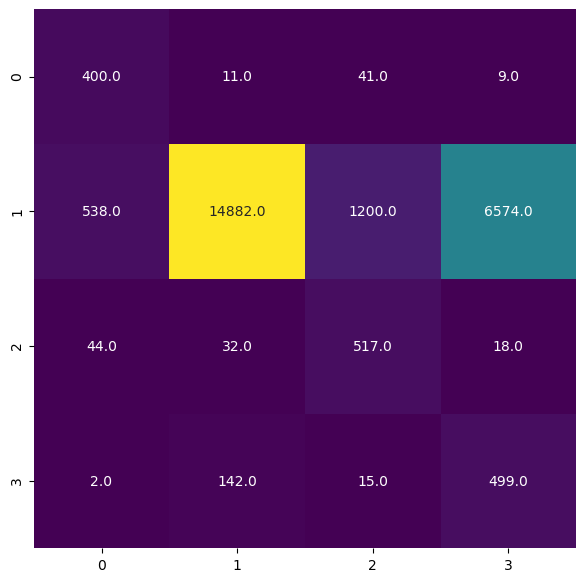

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)


In [25]:
model.featureImportances

SparseVector(27, {0: 0.1133, 1: 0.141, 2: 0.3164, 3: 0.1048, 4: 0.0494, 5: 0.0141, 6: 0.043, 7: 0.0063, 8: 0.0004, 9: 0.0087, 10: 0.0011, 11: 0.0064, 12: 0.0006, 13: 0.0004, 15: 0.0023, 16: 0.0023, 18: 0.014, 19: 0.0692, 20: 0.0605, 21: 0.0149, 22: 0.008, 23: 0.0076, 24: 0.0074, 25: 0.0042, 26: 0.0036})

In [26]:
prediction_counts = predictions.groupBy("prediction").count()

# Stampare i risultati
print("Counts of predictions in the test set:")
prediction_counts.show()

Counts of predictions in the test set:


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  984|
|       1.0|15067|
|       3.0| 7100|
|       2.0| 1773|
+----------+-----+



In [27]:
prediction_counts = predictions.groupBy("Severity").count()

# Stampare i risultati
prediction_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|23194|
|       3|  658|
|       2|  611|
|       0|  461|
+--------+-----+



Performing Undersampling(Severity=1) & Oversampling(Severity=0,2,3)

In [28]:
under_1=trainingData.filter(col('Severity') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [29]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_0)/n_0 
full_0=oversample_0

while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = oversample_0.unionAll(df_minority_oversampled)

14.344032096288867
13.344032096288867
12.344032096288867
11.344032096288867
10.344032096288867
9.344032096288867
8.344032096288867
7.344032096288867
6.344032096288867
5.344032096288867
4.344032096288867
3.344032096288867
2.344032096288867
1.344032096288867
0.344032096288867


In [30]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_2)/n_2
full_2=oversample_2

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = oversample_2.unionAll(df_minority_oversampled)

8.741595253790376
7.741595253790376
6.741595253790376
5.741595253790376
4.741595253790376
3.7415952537903756
2.7415952537903756
1.7415952537903756
0.7415952537903756


In [31]:
oversample_3=trainingData.filter(col('Severity') == 3)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_3)/n_3  
full_3=oversample_3

while num_campioni_da_generare>1:
    oversample_3 = oversample_3.unionAll(full_3)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_3.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = oversample_3.unionAll(df_minority_oversampled)

8.769993390614673
7.7699933906146725
6.7699933906146725
5.7699933906146725
4.7699933906146725
3.7699933906146725
2.7699933906146725
1.7699933906146725
0.7699933906146725


In [32]:
class0_counts=oversample_0.count()
class2_counts=oversample_2.count()
class3_counts=oversample_3.count()
class1_counts=under_1.count()
print(f'Class 0: {class0_counts}\nClass 1: {class1_counts}\nClass 2: {class2_counts}\nClass 3: {class3_counts}')

Class 0: 16322
Class 1: 17673
Class 2: 16313
Class 3: 16299


In [33]:
train_und_over=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(under_1)

In [34]:
g=train_und_over.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

23/12/14 20:52:58 WARN DAGScheduler: Broadcasting large task binary with size 2045.4 KiB


+--------+-----+
|Severity|Count|
+--------+-----+
|       0|16629|
|       1|16454|
|       2|16796|
|       3|16728|
+--------+-----+



In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
 
 

for max_depth in range (5,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=max_depth)
    
    
    # Train model.  This also runs the indexers.
    model = rf.fit(train_und_over)
    
    
    # Make predictions.
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")
    
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Max Depth : ",max_depth)
    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem
    
    avg_f1=sum_/4
    print('----------------------')
    
    print("avg_F1-Score: {:.2%}".format(avg_f1))

23/12/14 20:54:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/14 20:56:46 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 20:56:47 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 20:58:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:00:24 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:01:48 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:02:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:03:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:03:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.5274033060503932
Test Error = 0.472597


Max Depth :  5


Precision for class  0 : 44.51%
Recall for class  0 : 87.85%
avg_F1-Score for class  0 : 59.08%
----------------------------
Precision for class  1 : 98.76%
Recall for class  1 : 50.62%
avg_F1-Score for class  1 : 66.93%
----------------------------
Precision for class  2 : 39.18%
Recall for class  2 : 75.29%
avg_F1-Score for class  2 : 51.54%
----------------------------
Precision for class  3 : 4.92%
Recall for class  3 : 81.91%
avg_F1-Score for class  3 : 9.29%
----------------------------
[0.5908096280087527, 0.6693270244847932, 0.515406162464986, 0.09285898871565165]
----------------------
avg_F1-Score: 46.71%


23/12/14 21:05:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/14 21:07:21 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:07:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:09:18 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:11:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:12:41 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:13:20 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:13:51 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:14:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:14:55 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:15:31 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/12/14 21:16:11 WARN DAGScheduler: Broadcasting larg

0.7509228053281978
Test Error = 0.249077
Max Depth :  10


Precision for class  0 : 57.10%
Recall for class  0 : 87.20%
avg_F1-Score for class  0 : 69.01%
----------------------------
Precision for class  1 : 98.65%
Recall for class  1 : 74.78%
avg_F1-Score for class  1 : 85.07%
----------------------------
Precision for class  2 : 41.47%
Recall for class  2 : 82.32%
avg_F1-Score for class  2 : 55.15%
----------------------------
Precision for class  3 : 8.61%
Recall for class  3 : 70.97%
avg_F1-Score for class  3 : 15.35%
----------------------------
[0.6901287553648069, 0.8506964881302727, 0.5515350877192983, 0.1535426598717738]
----------------------
avg_F1-Score: 56.15%


23/12/14 21:19:05 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/14 21:20:52 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:20:53 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:22:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:24:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:26:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:27:17 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:27:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:28:20 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:28:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:29:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/12/14 21:30:33 WARN DAGScheduler: Broadcasting larg

0.8461322420157278
Test Error = 0.153868


23/12/14 21:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1503.0 KiB
23/12/14 21:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1514.6 KiB


Max Depth :  15


Precision for class  0 : 57.95%
Recall for class  0 : 84.60%
avg_F1-Score for class  0 : 68.78%
----------------------------
Precision for class  1 : 98.17%
Recall for class  1 : 85.50%
avg_F1-Score for class  1 : 91.40%
----------------------------
Precision for class  2 : 45.09%
Recall for class  2 : 82.65%
avg_F1-Score for class  2 : 58.35%
----------------------------
Precision for class  3 : 12.41%
Recall for class  3 : 55.32%
avg_F1-Score for class  3 : 20.28%
----------------------------
[0.6878306878306878, 0.9139722996796719, 0.5834777585210861, 0.20278551532033426]
----------------------
avg_F1-Score: 59.70%


23/12/14 21:40:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/14 21:41:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:41:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:43:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:45:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:46:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:47:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:47:41 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:48:12 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:48:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 21:49:24 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/12/14 21:50:12 WARN DAGScheduler: Broadcasting larg

0.8839271385010432
Test Error = 0.116073


23/12/14 22:05:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Max Depth :  20


23/12/14 22:06:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Precision for class  0 : 61.27%
Recall for class  0 : 83.73%
avg_F1-Score for class  0 : 70.76%
----------------------------
Precision for class  1 : 97.81%
Recall for class  1 : 89.91%
avg_F1-Score for class  1 : 93.69%
----------------------------
Precision for class  2 : 47.77%
Recall for class  2 : 80.52%
avg_F1-Score for class  2 : 59.96%
----------------------------
Precision for class  3 : 15.42%
Recall for class  3 : 45.59%
avg_F1-Score for class  3 : 23.05%
----------------------------
[0.7076076993583869, 0.9369397704041516, 0.5996343692870202, 0.2305032654629274]
----------------------
avg_F1-Score: 61.87%


<Axes: >

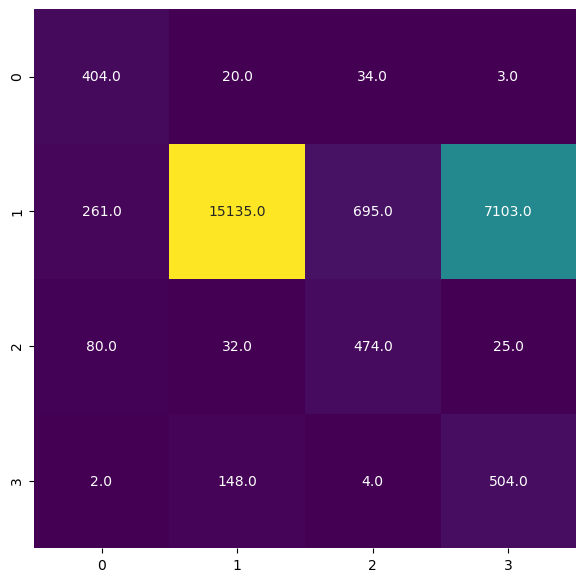

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [59]:
model.featureImportances

SparseVector(27, {0: 0.1074, 1: 0.1009, 2: 0.312, 3: 0.0882, 4: 0.0622, 5: 0.0175, 6: 0.0562, 7: 0.0116, 8: 0.0009, 9: 0.0083, 10: 0.0018, 11: 0.0091, 12: 0.0005, 13: 0.0004, 15: 0.0038, 16: 0.0024, 17: 0.0003, 18: 0.0194, 19: 0.0627, 20: 0.0804, 21: 0.0191, 22: 0.0069, 23: 0.0107, 24: 0.0102, 25: 0.0039, 26: 0.0033})

In [60]:
prediction_counts = predictions.groupBy("prediction").count()

# Stampare i risultati
print("Counts of predictions in the test set:")
prediction_counts.show()

Counts of predictions in the test set:


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  747|
|       1.0|15335|
|       3.0| 7635|
|       2.0| 1207|
+----------+-----+



In [61]:
prediction_counts = predictions.groupBy("Severity").count()

# Stampare i risultati
prediction_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|23194|
|       3|  658|
|       2|  611|
|       0|  461|
+--------+-----+



In [62]:

# Train a RandomForest model.
for max_depth in range (5,21,5):
    rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees=5,maxDepth=max_depth)
    
    
    # Train model.  This also runs the indexers.
    model = rf.fit(trainingData)
    
    
    # Make predictions.
    predictions = model.transform(testData)
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")
    
    accuracy = evaluator.evaluate(predictions)
    print(accuracy)
    print("Test Error = %g" % (1.0 - accuracy))
    from pyspark.mllib.evaluation import MulticlassMetrics
    # Calcolare precision, recall e F1-score
    predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictionAndLabels)
    print("Max Depth : ",max_depth)
    list_avg=[]
    for i in range(4):
        precision = metrics.precision(label=float(i))  
        recall = metrics.recall(label=float(i))
        f1Score= metrics.fMeasure(label=float(i)) # need .0
        print("Precision for class ",i,": {:.2%}".format(precision))
        print("Recall for class ",i,": {:.2%}".format(recall))
        print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
        list_avg.append(f1Score)
        print('----------------------------')
    sum_=0
    print(list_avg)
    for elem in list_avg:
        sum_+=elem
    
    avg_f1=sum_/4
    print('----------------------')
    
    print("avg_F1-Score: {:.2%}".format(avg_f1))

0.940178141550313
Test Error = 0.0598219


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Max Depth :  5


Precision for class  0 : 74.57%
Recall for class  0 : 47.07%
avg_F1-Score for class  0 : 57.71%
----------------------------
Precision for class  1 : 94.72%
Recall for class  1 : 99.36%
avg_F1-Score for class  1 : 96.99%
----------------------------
Precision for class  2 : 56.11%
Recall for class  2 : 27.82%
avg_F1-Score for class  2 : 37.20%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.5771276595744681, 0.9698678562410571, 0.37199124726477023, 0.0]
----------------------
avg_F1-Score: 47.97%


0.9473599743219387
Test Error = 0.05264
Max Depth :  10


Precision for class  0 : 74.61%
Recall for class  0 : 61.82%
avg_F1-Score for class  0 : 67.62%
----------------------------
Precision for class  1 : 95.73%
Recall for class  1 : 98.98%
avg_F1-Score for class  1 : 97.33%
----------------------------
Precision for class  2 : 66.25%
Recall for class  2 : 60.39%
avg_F1-Score for class  2 : 63.18%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.6761565836298932, 0.9732915041546549, 0.6318493150684932, 0.0]
----------------------
avg_F1-Score: 57.03%


23/12/14 22:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1217.1 KiB
23/12/14 22:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1608.5 KiB
23/12/14 22:19:37 WARN DAGScheduler: Broadcasting large task binary with size 2032.7 KiB
23/12/14 22:19:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/14 22:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1341.2 KiB
23/12/14 22:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB


0.9443508265125983
Test Error = 0.0556492


Max Depth :  15


23/12/14 22:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1341.2 KiB


Precision for class  0 : 73.15%
Recall for class  0 : 68.55%
avg_F1-Score for class  0 : 70.77%
----------------------------
Precision for class  1 : 95.83%
Recall for class  1 : 98.56%
avg_F1-Score for class  1 : 97.17%
----------------------------
Precision for class  2 : 67.30%
Recall for class  2 : 58.27%
avg_F1-Score for class  2 : 62.46%
----------------------------
Precision for class  3 : 5.50%
Recall for class  3 : 0.91%
avg_F1-Score for class  3 : 1.56%
----------------------------
[0.7077267637178052, 0.9717309981295698, 0.6245614035087719, 0.01564537157757497]
----------------------
avg_F1-Score: 57.99%


23/12/14 22:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1217.1 KiB
23/12/14 22:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1608.5 KiB
23/12/14 22:20:00 WARN DAGScheduler: Broadcasting large task binary with size 2032.7 KiB
23/12/14 22:20:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/14 22:20:01 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/12/14 22:20:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/12/14 22:20:03 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/12/14 22:20:04 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
23/12/14 22:20:06 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/12/14 22:20:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


0.938613384689456
Test Error = 0.0613866


23/12/14 22:20:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Max Depth :  20


23/12/14 22:20:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Precision for class  0 : 71.63%
Recall for class  0 : 66.81%
avg_F1-Score for class  0 : 69.14%
----------------------------
Precision for class  1 : 95.83%
Recall for class  1 : 97.92%
avg_F1-Score for class  1 : 96.86%
----------------------------
Precision for class  2 : 65.31%
Recall for class  2 : 57.94%
avg_F1-Score for class  2 : 61.41%
----------------------------
Precision for class  3 : 7.97%
Recall for class  3 : 3.04%
avg_F1-Score for class  3 : 4.40%
----------------------------
[0.691358024691358, 0.9686320503251946, 0.614050303555941, 0.044004400440044]
----------------------
avg_F1-Score: 57.95%


# Decision Tree con iperparametri di default

In [63]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

+--------+-----+
|Severity|Count|
+--------+-----+
|       0|  997|
|       1|54316|
|       2| 1517|
|       3| 1513|
+--------+-----+



Train & Test a DT without Severity sampling

In [64]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(trainingData)

In [65]:
dt.featureImportances

SparseVector(27, {0: 0.1506, 1: 0.0474, 2: 0.5923, 12: 0.0008, 18: 0.0093, 19: 0.1633, 20: 0.0314, 21: 0.0036, 22: 0.0013})

In [66]:
predictions = dt.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

0.9469186326432354
Test Error = 0.0530814


DenseMatrix([[3.6600e+02, 6.6000e+01, 2.9000e+01, 0.0000e+00],
             [1.3500e+02, 2.2849e+04, 2.1000e+02, 0.0000e+00],
             [5.0000e+01, 1.7500e+02, 3.8600e+02, 0.0000e+00],
             [0.0000e+00, 6.5500e+02, 3.0000e+00, 0.0000e+00]])


Precision for class  0 : 66.42%
Recall for class  0 : 79.39%
avg_F1-Score for class  0 : 72.33%
----------------------------
Precision for class  1 : 96.23%
Recall for class  1 : 98.51%
avg_F1-Score for class  1 : 97.36%
----------------------------
Precision for class  2 : 61.46%
Recall for class  2 : 63.18%
avg_F1-Score for class  2 : 62.31%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.7233201581027668, 0.973561430793157, 0.6230831315577079, 0.0]
----------------------
avg_F1-Score: 58.00%


<Axes: >

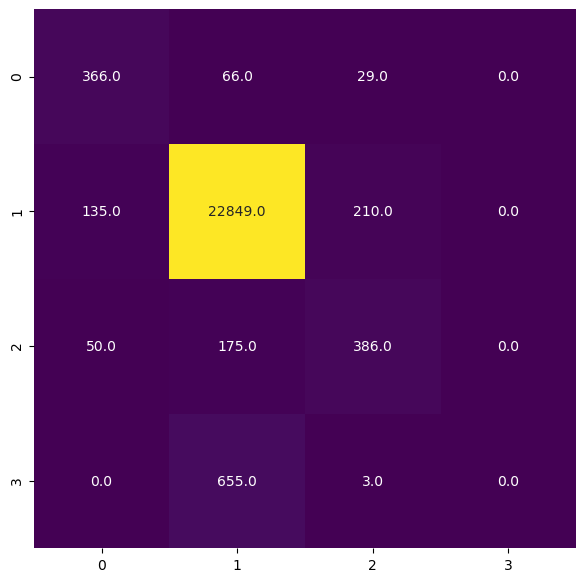

In [67]:
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Train & Test a tuned DT without Severity sampling

In [68]:
n=trainingData.count()
max_depth=[5,15,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.9449125341036752
Test Error = 0.0550875


Precision for class  0 : 76.20%
Recall for class  0 : 54.88%
avg_F1-Score for class  0 : 63.81%
----------------------------
Precision for class  1 : 95.60%
Recall for class  1 : 98.88%
avg_F1-Score for class  1 : 97.21%
----------------------------
Precision for class  2 : 60.36%
Recall for class  2 : 59.57%
avg_F1-Score for class  2 : 59.97%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.6380832282471626, 0.9721297925100143, 0.599670510708402, 0.0]
----------------------
avg_F1-Score: 55.25%


<Axes: >

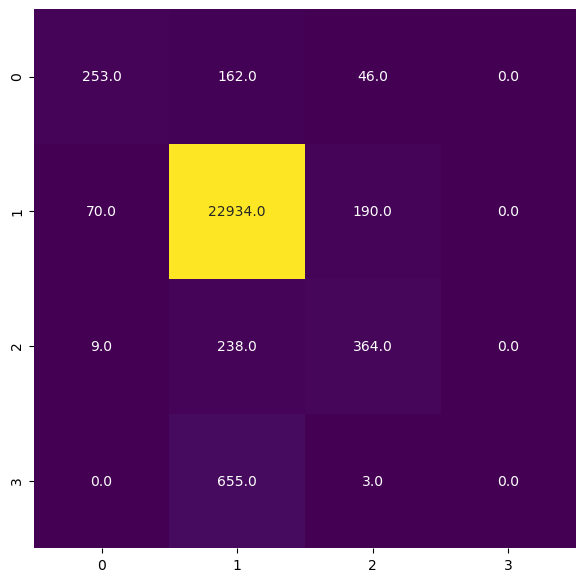

In [69]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=10, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Undersampling Severity target

In [70]:
g_p=g.toPandas()
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]
n_2=g_p.iloc[2,1]
n_3=g_p.iloc[3,1]

In [71]:
und=(n_0+n_2+n_3)/3
train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})
result_counts=train_und.groupBy("Severity").count()
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 1365|
|       3| 1513|
|       2| 1517|
|       0|  997|
+--------+-----+



Training & Test a DT

In [72]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(train_und)
                                                                                
dt.featureImportances

SparseVector(27, {0: 0.1773, 1: 0.1444, 2: 0.5207, 3: 0.0069, 4: 0.0011, 7: 0.001, 9: 0.016, 15: 0.0031, 18: 0.0048, 19: 0.1054, 20: 0.0194})

In [73]:
predictions = dt.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.5605039319531375
Test Error = 0.439496


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 63.30%
Recall for class  0 : 84.16%
avg_F1-Score for class  0 : 72.25%
----------------------------
Precision for class  1 : 99.10%
Recall for class  1 : 53.91%
avg_F1-Score for class  1 : 69.84%
----------------------------
Precision for class  2 : 38.59%
Recall for class  2 : 81.67%
avg_F1-Score for class  2 : 52.42%
----------------------------
Precision for class  3 : 5.56%
Recall for class  3 : 87.84%
avg_F1-Score for class  3 : 10.45%
----------------------------
[0.7225325884543761, 0.6983692616999889, 0.5241596638655462, 0.10453969976487612]
----------------------
avg_F1-Score: 51.24%


<Axes: >

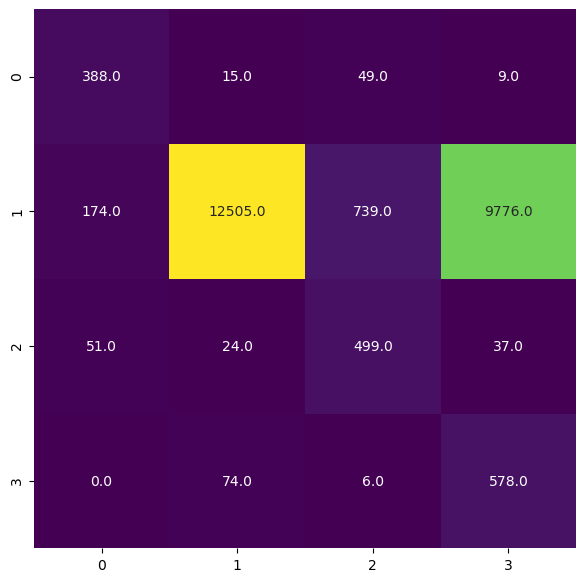

In [74]:
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

In [75]:
prediction_counts = predictions.groupBy("Severity").count()
prediction_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|23194|
|       3|  658|
|       2|  611|
|       0|  461|
+--------+-----+



In [76]:
prediction_counts = predictions.groupBy("prediction").count()
print("Counts of predictions in the test set:")
prediction_counts.show()

Counts of predictions in the test set:


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  613|
|       1.0|12618|
|       3.0|10400|
|       2.0| 1293|
+----------+-----+



In [77]:
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[3.8800e+02, 1.5000e+01, 4.9000e+01, 9.0000e+00],
             [1.7400e+02, 1.2505e+04, 7.3900e+02, 9.7760e+03],
             [5.1000e+01, 2.4000e+01, 4.9900e+02, 3.7000e+01],
             [0.0000e+00, 7.4000e+01, 6.0000e+00, 5.7800e+02]])


Train & Test a tuned DT with Severity Undersampling

In [78]:
n=train_und.count()
max_depth=[5,15,10,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

0.7105199807414541
Test Error = 0.28948


Precision for class  0 : 54.70%
Recall for class  0 : 84.60%
avg_F1-Score for class  0 : 66.44%
----------------------------
Precision for class  1 : 98.80%
Recall for class  1 : 70.29%
avg_F1-Score for class  1 : 82.14%
----------------------------
Precision for class  2 : 37.67%
Recall for class  2 : 84.78%
avg_F1-Score for class  2 : 52.17%
----------------------------
Precision for class  3 : 7.86%
Recall for class  3 : 75.68%
avg_F1-Score for class  3 : 14.24%
----------------------------
[0.6643952299829643, 0.8214132762312635, 0.5216515609264853, 0.14242814242814242]
----------------------
avg_F1-Score: 53.75%


<Axes: >

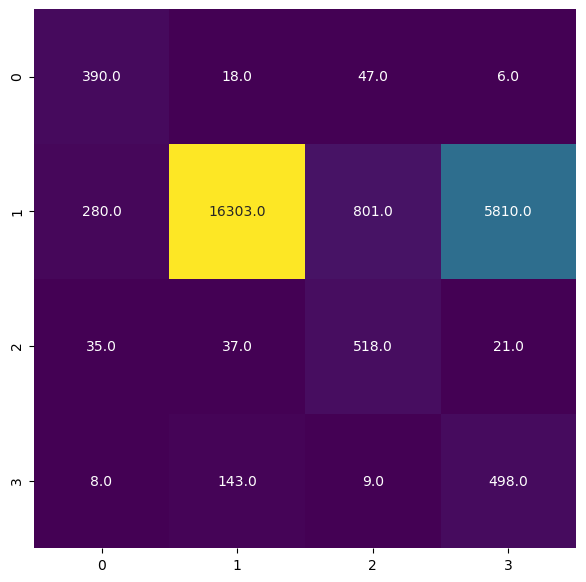

In [79]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=15, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(train_und)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Performing Undersampling(Severity=1) & Oversampling(Severity=0,2,3)

In [80]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(train_und_over)

23/12/14 22:21:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/14 22:23:32 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:23:33 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:25:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:27:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:29:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:29:30 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:30:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:30:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


In [81]:
dt.featureImportances

SparseVector(27, {0: 0.2122, 1: 0.114, 2: 0.5022, 3: 0.0084, 4: 0.0028, 9: 0.0221, 18: 0.0074, 19: 0.1163, 21: 0.0146})

In [82]:
predictions = dt.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem
    
avg_f1=sum_/4
print('----------------------')
    
print("avg_F1-Score: {:.2%}".format(avg_f1))
    

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.6626945915583373
Test Error = 0.337305


Precision for class  0 : 54.08%
Recall for class  0 : 87.64%
avg_F1-Score for class  0 : 66.89%
----------------------------
Precision for class  1 : 98.70%
Recall for class  1 : 65.25%
avg_F1-Score for class  1 : 78.56%
----------------------------
Precision for class  2 : 39.27%
Recall for class  2 : 77.58%
avg_F1-Score for class  2 : 52.15%
----------------------------
Precision for class  3 : 6.60%
Recall for class  3 : 76.60%
avg_F1-Score for class  3 : 12.15%
----------------------------
[0.6688741721854304, 0.785641983960134, 0.5214521452145215, 0.12154829374170986]
----------------------
avg_F1-Score: 52.44%


<Axes: >

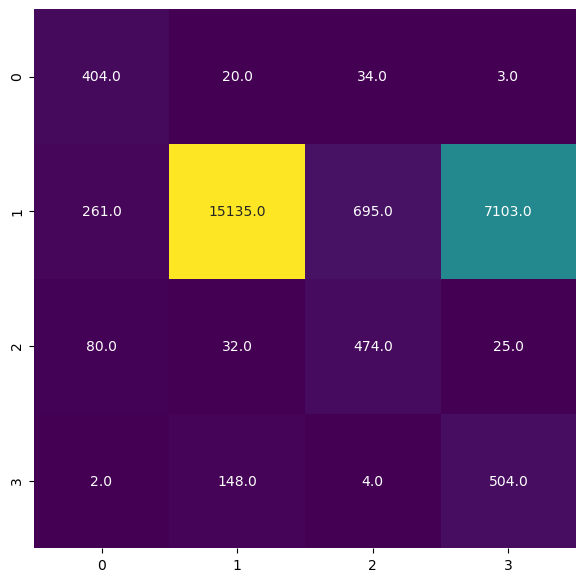

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Train & Test a tuned DT with Severity Undersampling + Oversampling

In [84]:
n=train_und_over.count()
max_depth=[5,15,10,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

23/12/14 22:31:21 WARN DAGScheduler: Broadcasting large task binary with size 2035.3 KiB


23/12/14 22:33:11 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/14 22:34:59 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:34:59 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:36:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:38:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:41:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:42:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:43:11 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:43:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:44:29 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:45:08 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/12/14 22:45:51 WARN DAGScheduler: Broadcasting larg

0.7334296260632323
Test Error = 0.26657


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 45.83%
Recall for class  0 : 85.90%
avg_F1-Score for class  0 : 59.77%
----------------------------
Precision for class  1 : 98.74%
Recall for class  1 : 72.89%
avg_F1-Score for class  1 : 83.86%
----------------------------
Precision for class  2 : 35.82%
Recall for class  2 : 84.12%
avg_F1-Score for class  2 : 50.24%
----------------------------
Precision for class  3 : 8.45%
Recall for class  3 : 70.67%
avg_F1-Score for class  3 : 15.09%
----------------------------
[0.5977358490566037, 0.8386456653850924, 0.5024437927663734, 0.15092502434274585]
----------------------
avg_F1-Score: 52.24%


<Axes: >

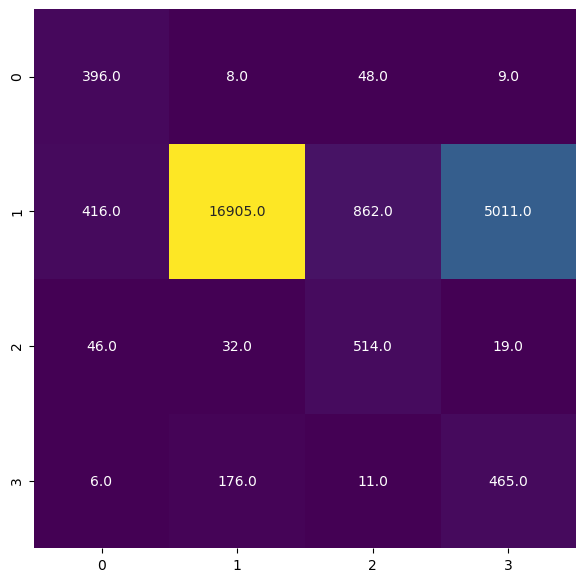

In [85]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=15, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(train_und_over)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False,              xticklabels=labels, 
            yticklabels=labels)